#COVID-19 Status and Cough Recordings


## Import Packages 

First we import all required Python packages that we need during the project. 

In [ ]:
import pandas as pd                # the pandas package provides tools for storing and manipulating dataframes
import numpy as np                 # numpy package for working with arrays of numbers 
from scipy.io import wavfile       # package for reading in data from audio files (*.wav)
from scipy.fft import fft, fftfreq # package for fast methods to compute discrete Fourier transform
import matplotlib.pyplot as plt    # package for functions to plot numeric data
import os                          # package for using filesystem
from sklearn.model_selection import train_test_split # function to split data into a training and a testset
from sklearn.linear_model import LogisticRegression  # package for logistic regression
from sklearn import tree                             # package for decision trees 

## Step 1 - Read In

Let us first read in the metadata stored in the file "Covid19Study.csv". The metadata contains a list of individuals along with their age, sex ("m" or "f") and their Covid19 infection status ("y" or "n"). The invidiuals are number by an index $l = 1,\ldots,m$ with the sample size $m$. 

In [ ]:
df = pd.read_csv('Covid19Study_June2021.csv',sep=';')    # read in data from Covid19Study.csv into dataframe "df"
print(df.head(5))
uniquepart = df["ParticipantID"].unique()       # determine a list of all individuals

samplesize = len(uniquepart)                    # count the number of individuals and store in the variable `samplesize`
#samplesize= 5

   ParticipantID  Age Sex Covid19
0              1   29   f       y
1              2   40   m       y
2              3   37   f       n
3              4   40   m       n
4              5   16   m       y


The code snippet below uses the `dataframe` method [`value_counts()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html) to determine and plot a histogram for the attribute "Covid19" of all individuals. We then use the `numpy` method histogram to compute the histogram for the colum (attribute) "Age". This method returns a numpy array whose elements are the counts for each histogram interval. We then plot this numpy array as a bar plot using [`ax.bar()`](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py).

[ 96 100   4]
[0 1 2]
0      29
1      40
2      37
3      40
4      16
       ..
195    20
196    33
197    27
198    49
199    31
Name: Age, Length: 200, dtype: int64


[Text(0, 0, '0-30'), Text(0, 0, '31-50'), Text(0, 0, '51-150')]

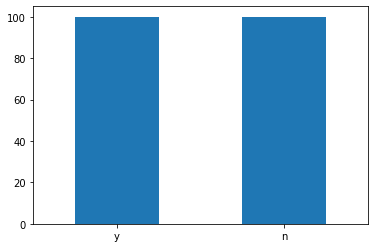

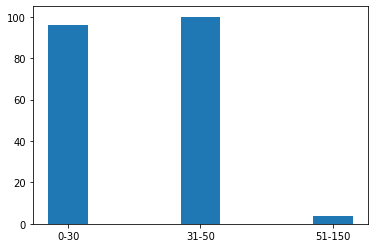

In [ ]:
counts = df['Covid19'].value_counts()        # use value_counts () to compute a histogram of attribute "Covid19"
labelvals = df['Covid19'].unique()           # use unique() to determine a list of different attribute values 
ax = counts.plot.bar(x='lab', y='val', rot=0)# use counts.plot.bar() to plot the histogram of attribute "Covid19"

ages= df['Age']                              # extract the attribute column "Age" from df and store in variable "ages"
histage=np.histogram(ages,[0,30,50,150] )    # use np.histogram() to compute histogram with intervals 0-30,31-50,51-150
histage = histage[0]
                    
print(histage)
x = np.arange(len(histage))                # create a numpay array with values 1,2,3 

print(x)
print(ages)

agegroups = ['0-30', '31-50', '51-150']     # create a list with histogram interval labels "0-30", "31-50", "51-150"

fig, ax = plt.subplots()                           # create a figure and axis ojbect using plt.subplots()
rects1 = ax.bar(x,histage, 0.3, label="Age Groups")# plot the Age histrogrum using "ax.bar() ax.set_xticks(x)
ax.set_xticks(x)
ax.set_xticklabels(agegroups)                      # add labels for histogram intervals using ax.set_xticklabels()

The code snippet below iterates over the first four participants that are listed in the metadata stored in `Covid19Study_June2021.csv`. For each participant, we first probe if there is a ".wav" file with the filename "ParticipantRecording??.wav" in the folder `/Recordings`. Here `??` represents a running index starting from 1. Probing if a file with given name exists can be done with the function [`os.path.isfile(filename)`](https://livebook.manning.com/book/hello-world/chapter-24/point-9977-115-115-0). If we can find such a file for an participant, we plot the **last** $N=8192$ signal samples. If there is no ".wav" file present for an participant, we plot a "virtual" recording whose signal samples are all equal to zero. 

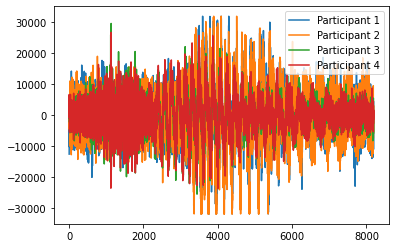

In [ ]:
N = 8192

pathbase = os.path.join(os.getcwd(), "Recordings/")# create full path of the folder "Recordings" and store in "pathbase"

SignalSamples = np.zeros((samplesize,N)) # create all-zeroes numpy array `SignalSamples' of shape (m,N) 
t = np.arange(N)      # create a list of signal sample indices 0,2,...,N-1

# the for loop uses the iteration counter participationid_m1 which is the participant id minus 1 

for participantid_m1 in range(4): 
    
    # first construct filename for current participant
    # the filename consists of three parts: 1. "RecordingParicipant", 2. the participant index, 3. ".wav"
    # the wav file for the first participant is "RecordingParicipant1.wav", for the second participant it is 
    # "RecordingParicipant2.wav" and so on. 
    
    partfilename = "RecordingParticipant%d"%(participantid_m1+1)
    # construct full path by concatenating path with filename
    fullfilename = pathbase+partfilename + ".wav"
    # check if there is a file with given filename 
    if os.path.isfile(fullfilename):
        # load the recording from the wav file
        fs, data = wavfile.read(fullfilename)     
        # store the last N signal samples in the corresponding row of the numpy array 'SignalSamples'
        SignalSamples[participantid_m1,:] = data[-(N+1):-1] 
    else:
        print("no file")     
    plt.plot(t, SignalSamples[participantid_m1,:],label="Participant %d"%(participantid_m1+1)) # add the last N samples of the recording to the plot 
plt.legend()    # add legend plot 
plt.show()      # show plot
   
  #  X_steps[sampleidx,:] = x1[:]
   # print(x1)
    #fullpath = os.path.join(pathbase,filename,".csv")

## Step 2 - Features and Labels

We now construct a feature vector for each participant listed in `Covid19Study_June2021.csv` using the Fourier transform of the audio recording stored in the corresponding wav file. For each participant, there is a separate wav file. Let us denote the audio recording of a participant by $x[0],\ldots,x[N-1]$ with $N=8192$. The signal values $x[0],\ldots,x[N-1]$ are obtained from the last $N$ signal samples stored in the corresponding wav file. 

A popular construction for the features of audio recordings is via the discrete Fourier transform 
$$X[k] = \sum_{n=0}^{N-1} x[n] \exp( - j 2 \pi n k /N).$$ 
We then form the features characterizing the participant by normalized absolute values $(1/c) |X[k]|$ for $k=400,600,800,1000$ with the normalization constant $c = \max_{k=0,\ldots,N-1} |X[k]|$. 

We then store the feature vectors of all participants listed in `Covid19Study_June2021.csv` in the rows of the numpy array `X` with shape `(m,n)` where `n` is the length of the feature vectors. The code snippet also creates a numpy array `y` with shape `(m,1)`. The j-th entry of `y` is set to 1 if the corresponding individuals has value `y` for the attribute "Covid19". 

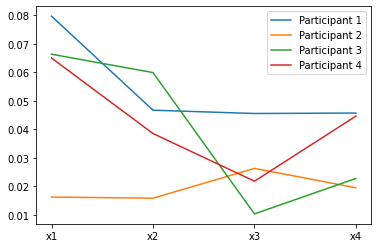

In [ ]:
fftlen = 8192
# list of frequency values that are used to construct the feature values 
freqbins = [400,600,800,1000]   
nrfreqbins = len(freqbins)

# create numpy array 'X', initalized with all zero entries
X = np.zeros((samplesize,nrfreqbins))    
# create numpy array 'y' initalized with all one entries  
y = np.ones((samplesize,1))                 

covid19field = df['Covid19']  # read in the attribute "Covid19" from dataframe df 

 
fig, ax = plt.subplots()  

# iterate over participants, the iteration variable is participant-id minus 1 

for participantid_m1 in range(samplesize):    
    # first construct filename for current participant
    # the filename consists of three parts: 1. "RecordingParicipant", 2. the participant index, 3. ".wav"
    partfilename = "RecordingParticipant%d"%(participantid_m1+1)
    # construct full-path by concatenating path with filename
    fullfilename = pathbase+partfilename + ".wav"
    # check if file with given full-path exists
    if os.path.isfile(fullfilename):
        # load the recording from the wav file
        fs, data = wavfile.read(fullfilename)    
        # store the last N audio samples of the wav file in the numpy array audiosignal 
        audiosignal=data[-(fftlen+1):-1]  
        # compute absolute values of DFT of length-N signal  
        spectrum = np.abs(fft(audiosignal,fftlen))    
    else:
        # compute absolute values of fft with length N
        spectrum = np.zeros(fftlen)       
        print("no file")     
    if ((covid19field[participantid_m1]=="n")): 
        # set jth entry of numpy array `y` to -1 if j-th Individuals had been reported a Covid-19 infected
        y[participantid_m1]=-1          
    # construct feature vector by using spectrum values at frequencies 400,600,800,1000 
    featurevec = spectrum[freqbins]/np.max(spectrum) 
    # store feature vector for r-th participant in the r-1 th row of 'X'
    X[participantid_m1,:] = featurevec              
    # check if the current participant belongs to the first four participants
    if participantid_m1 in range(4): 
        # plot the feature vector entries for the participant 
        ax.plot(np.arange(nrfreqbins), featurevec,label="Participant %d" % (participantid_m1+1)) # plotting t, a separately 

ax.set_xticks(range(len(freqbins)))
ax.set_xticklabels(['x1','x2','x3','x4'])                      # add labels for histogram intervals using ax.set_xticklabels()
plt.legend()
plt.show()

## Step 3 - Basic ML Methods

The code snippet below splits the datapoints into a training and a test set. The feature vectors and label values for datapoints in the training set are stored in the numpy array `X_train` and `y_train`. The feature vectors and label values for datapoints in the test set are stored in the numpy array `X_test` and `y_test`. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42) 

In [ ]:
clf1 = LogisticRegression() # create a LogisticRegression() object "clf1"
clf1.fit(X_train, y_train)  # learn a hypothesis on the training set using the method clf1.fit() 

print("trainset accuracy logistic regression: ", clf1.score(X_train,y_train))
print("testset accuracy logistic regression: ", clf1.score(X_test,y_test))

clf2 = tree.DecisionTreeClassifier() # create a DecitionTreeClassifier() object "clf2" using "max_depth=1"
clf2 = clf2.fit(X_train, y_train) # learn a hypothesis on the training set using the method clf2.fit() 

print("trainset accuracy decision tree: ", clf2.score(X_train,y_train))
print("testset accuracy decision tree: ", clf2.score(X_test,y_test))

print(X_train.shape)

print("feature coefficients obtained from logistic regression:", clf1.coef_/np.linalg.norm(clf1.coef_))
print("feature importances obtained from decision tree:",clf2.tree_.compute_feature_importances(normalize=False))

trainset accuracy logistic regression:  0.52
testset accuracy logistic regression:  0.48
trainset accuracy decision tree:  1.0
testset accuracy decision tree:  0.8
(100, 4)
feature coefficients obtained from logistic regression: [[-0.42909803  0.17316125  0.74899679  0.47422977]]
feature importances obtained from decision tree: [0.08928289 0.11521458 0.23374981 0.06095272]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
